# Multicollinearity-PCR/RR
## 背景描述  

McDonald和Schwing(1973)提出了一项研究，将总死亡率与气候、社会经济和污染变量联系起来，本研究选择了 15 个自变量列于下表。因变量是以上原因在年龄调整后的总死亡率。我们不对该研究的流行病学方面作评论，而仅仅作为变量选择的说明性例子使用这些数据。  
由此我们构造了 60 个观测的 15 个变量，具体请见下表：

## 数据描述

|     变量名      |            变量含义            |      变量类型       |  变量取值范围  |
| :-------------: | :----------------------------: | :-----------------: | :------------: |
|  （自变量1）X1  |       年平均降水量(英寸)       | continuous variable | $\mathbb{R}^+$ |
|  （自变量2）X2  |      一月平均气温(华氏度)      | continuous variable | $\mathbb{R}^+$ |
|  （自变量3）X3  |      七月平均气温(华氏度)      | continuous variable | $\mathbb{R}^+$ |
|  （自变量4）X4  |      占65岁以上人口的比例      | continuous variable | $\mathbb{R}^+$ |
|  （自变量5）X5  |          每个家庭人口          | continuous variable | $\mathbb{R}^+$ |
|  （自变量6）X6  |         完成的平均学制         | continuous variable | $\mathbb{R}^+$ |
|  （自变量7）X7  |     健全的住房单位的百分比     | continuous variable | $\mathbb{R}^+$ |
|  （自变量8）X8  |         每平方英里人口         | continuous variable | $\mathbb{R}^+$ |
|  （自变量9）X9  |       占非白人人口的比例       | continuous variable | $\mathbb{R}^+$ |
| （自变量10）X10 |        白领工作的就业率        | continuous variable | $\mathbb{R}^+$ |
| （自变量11）X11 | 收入在3000美元以下家庭的百分比 | continuous variable | $\mathbb{R}^+$ |
| （自变量12）X12 |    碳氢化合物的相对污染潜力    | continuous variable | $\mathbb{R}^+$ |
| （自变量13）X13 |     氮氧化物的相对污染潜力     | continuous variable | $\mathbb{R}^+$ |
| （自变量14）X14 |     二氧化硫的相对污染潜力     | continuous variable | $\mathbb{R}^+$ |
| （自变量15）X15 |         相对湿度百分比         | continuous variable | $\mathbb{R}^+$ |
|   （因变量）Y   |  所有原因经年龄调整的总死亡率  | continuous variable | $\mathbb{R}^+$ |

## 问题 
注：这里使用 \alpha=0.05 的显著性水平

上次实验已经判断该数据存在多重共线性，尝试使用主成分回归和岭回归消除多重共线性。这次作业数据与课件数据的主要区别在于样本量的大小不同，对于作业的60个样本数据，不便于直接划分训练集和测试集，因此需要大家采用留一法（即n折交叉验证）进行。对于前三问，直接使用前59个数据展示回归分析的过程（为了简化结果）；对于第四问，采用留一法展示60种模型在60种测试用例上的效果（以RMSE或MSE为指标）。

主成分回归：
1. 选择适当的主成分.
2. 对降维后的数据进行回归分析.

岭回归：
3. 选择适当的岭参数.
4. 进行岭回归分析并在测试用例上做预测，比较最小二乘、主成分回归和岭回归建立的模型在测试集上的效果.

## 解决方案

In [1]:
# Import standard packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Import additional packages
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA  # 进行主成分分析
from sklearn import linear_model  # 进行岭回归分析
from ipywidgets import interact  # 互动功能
%matplotlib inline 

alpha = 0.05
p = 15
n = 60 #数据集样本个数
n_train = 59 #划分数据集，训练集的样本个数

x = pd.read_csv('Air_Pollution.csv')
x.insert(0, 'intercept', np.ones(len(x))) 
data = x.values * 1
df = pd.DataFrame(data)
print(df.head())

#要把所有n个数据拿出来，为最后的留一法做准备
X = data[0:n,0:p+1]
Y = data[0:n,-1]

#划分训练集
X_tr = data[0:n_train,0:p+1]
Y_tr = data[0:n_train,-1]

#划分测试集
X_tst = data[n_train:n+1,0:p+1]
Y_tst = data[n_train:n+1,-1]

    0     1     2     3     4     5     6     7       8     9     10    11  \
0  1.0  36.0  27.0  71.0   8.1  3.34  11.4  81.5  3243.0   8.8  42.6  11.7   
1  1.0  35.0  23.0  72.0  11.1  3.14  11.0  78.8  4281.0   3.5  50.7  14.4   
2  1.0  44.0  29.0  74.0  10.4  3.21   9.8  81.6  4260.0   0.8  39.4  12.4   
3  1.0  47.0  45.0  79.0   6.5  3.41  11.1  77.5  3125.0  27.1  50.2  20.6   
4  1.0  43.0  35.0  77.0   7.6  3.44   9.6  84.6  6441.0  24.4  43.7  14.3   

     12    13     14    15       16  
0  21.0  15.0   59.0  59.0   921.87  
1   8.0  10.0   39.0  57.0   997.88  
2   6.0   6.0   33.0  54.0   962.35  
3  18.0   8.0   24.0  56.0   982.29  
4  43.0  38.0  206.0  55.0  1071.29  


**数据预处理：**

In [2]:
# 对数据进行标准化
# 自变量 X 的均值
X_mean = []
for i in range(p):
    X_mean.append(np.mean(X_tr[:, i+1])) 

# 自变量 X 的标准差
X_L = []
for i in range(p):
    X_L.append(sum((X_tr[:, i+1] - X_mean[i]) ** 2))  

# 对自变量 X 标准化(截距项不用标准化)
X_std = X_tr * 1.0
X_std[:,1:p+1] = (X_tr[:,1:p+1] - X_mean) / np.sqrt(X_L)

df_std = pd.DataFrame(X_std)
df_std['Y'] = Y_tr
print(df_std.head()) 


     0         1         2         3         4         5         6         7  \
0  1.0 -0.017680 -0.090975 -0.099390 -0.061927  0.079270  0.065058  0.014383   
1  1.0 -0.030720 -0.142340 -0.071988  0.204765 -0.117654  0.003397 -0.054013   
2  1.0  0.086634 -0.065293 -0.017184  0.142537 -0.048730 -0.181588  0.016917   
3  1.0  0.125752  0.140163  0.119825 -0.204162  0.148194  0.018812 -0.086945   
4  1.0  0.073595  0.011753  0.065022 -0.106375  0.177732 -0.212419  0.092913   

          8         9        10        11        12        13        14  \
0 -0.057366 -0.044844 -0.105561 -0.084469 -0.024437 -0.021963  0.010239   
1  0.035637 -0.122188  0.130176  0.000106 -0.042848 -0.036017 -0.030856   
2  0.033756 -0.161590 -0.198692 -0.062542 -0.045680 -0.047261 -0.043184   
3 -0.067938  0.222214  0.115624  0.194316 -0.028685 -0.041639 -0.061677   
4  0.229169  0.182812 -0.073547 -0.003026  0.006721  0.042687  0.312283   

         15        Y  
0  0.032463   921.87  
1 -0.016026   997.88  

In [3]:
# 对数据进行标准化
# 自变量 X 的均值
X_mean = []
for i in range(p):
    X_mean.append(np.mean(X[:, i+1])) 

# 自变量 X 的标准差
X_L = []
for i in range(p):
    X_L.append(sum((X[:, i+1] - X_mean[i]) ** 2))  

# 对自变量 X 标准化(截距项不用标准化)  最后留一法中用到

X_std_1 = X * 1.0
X_std_1[:,1:p+1] = (X[:,1:p+1] - X_mean) / np.sqrt(X_L)

**对原始数据做多元线性回归分析**

In [4]:
model = sm.OLS(Y_tr, X_tr).fit()
Y_hat = model.fittedvalues
beta_hat = model.params
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     9.346
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           3.86e-09
Time:                        16:28:48   Log-Likelihood:                -284.63
No. Observations:                  59   AIC:                             601.3
Df Residuals:                      43   BIC:                             634.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1786.3713    446.848      3.998      0.000     885.217    2687.526
x1             1.9502      0.943      2.069      0.045       0.049       3.852
x2            -2.0267      1.151     -1.761      0.085      -4.348       0.294
x3            -3.1056      1.921     -1.616      0.113      -6.980       0.769
x4            -9.8072      8.856     -1.107      0.274     -27.666       8.052
x5          -113.3003     73.101     -1.550      0.128    -260.722      34.122
x6           -18.0841     12.298     -1.470      0.149     -42.886       6.718
x7            -0.5835      1.797     -0.325      0.747      -4.208       3.041
x8             0.0035      0.004      0.862      0.394      -0.005       0.012
x9             4.3837      1.360      3.224      0.002       1.641       7.126
x10           -0.0157      1.755     -0.009      0.993      -3.555       3.524
x11            0.0343      3.316      0.010      0.992      -6.652       6.721
x12           -0.6732      0.496     -1.357      0.182      -1.674       0.327
x13            1.3485      1.016      1.327      0.192      -0.701       3.398
x14            0.0858      0.149      0.576      0.568      -0.215       0.386
x15            0.1379      1.185      0.116      0.908      -2.252       2.528
==============================================================================
Omnibus:                        2.690   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                1.812
Skew:                           0.356   Prob(JB):                        0.404
Kurtosis:                       3.481   Cond. No.                     4.07e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**对X标准化后的数据做多元线性回归分析**

In [5]:
model_std = sm.OLS(Y_tr, X_std).fit()
Y_std_hat = model_std.fittedvalues
beta_std_hat = model_std.params
model_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     9.346
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           3.86e-09
Time:                        16:28:48   Log-Likelihood:                -284.63
No. Observations:                  59   AIC:                             601.3
Df Residuals:                      43   BIC:                             634.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        940.1198      4.594    204.643      0.000     930.855     949.384
x1           149.5666     72.305      2.069      0.045       3.750     295.383
x2          -157.8279     89.632     -1.761      0.085    -338.589      22.933
x3          -113.3347     70.112     -1.616      0.113    -254.730      28.061
x4          -110.3211     99.617     -1.107      0.274    -311.218      90.575
x5          -115.0701     74.243     -1.550      0.128    -264.795      34.655
x6          -117.3116     79.779     -1.470      0.149    -278.201      43.577
x7           -23.0360     70.949     -0.325      0.747    -166.117     120.045
x8            39.2125     45.500      0.862      0.394     -52.547     130.972
x9           300.3883     93.185      3.224      0.002     112.462     488.314
x10           -0.5392     60.311     -0.009      0.993    -122.168     121.090
x11            1.0946    105.851      0.010      0.992    -212.374     214.563
x12         -475.3253    350.263     -1.357      0.182   -1181.698     231.048
x13          479.7590    361.528      1.327      0.192    -249.331    1208.849
x14           41.7678     72.534      0.576      0.568    -104.511     188.046
x15            5.6896     48.880      0.116      0.908     -92.887     104.266
==============================================================================
Omnibus:                        2.690   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                1.812
Skew:                           0.356   Prob(JB):                        0.404
Kurtosis:                       3.481   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Q1：选择适当的主成分

In [6]:
print(X_std.shape)

(59, 16)


**求 $(X^*)^{'}(X^*)$ 矩阵的特征值和特征向量:**

In [7]:
#求 (X*)'(X*) 矩阵
R = np.dot(X_std.T,X_std) 
R = pd.DataFrame(R[1:,1:])

R.shape

(15, 15)

In [8]:
# 求特征值 & 特征向量
W, V = np.linalg.eig(R)
W_diag = np.diag(W)
V = V.T # 需要转置

print('特征值:', W)
# print(W_diag)
print(sum(W)) # 验证特征值求和值为 p
VV = np.dot(V,V.T)
VV = pd.DataFrame(VV)

特征值: [4.55116842 2.74044208 2.06596127 1.3486822  1.20349098 0.96061198
 0.61434732 0.47220353 0.36913661 0.00486884 0.04243901 0.22049677
 0.16634338 0.12525641 0.1145512 ]
15.000000000000005


**判断 X 矩阵是否具有多重共线性:**

In [9]:
# 定义"判断多重共线性"的函数
# 参数: (X_list: 设计矩阵 X, thres_vif: VIF 方法判断多重共线性的阈值, thres_kappa: 特征值方法判断多重共线性的阈值)
def judge_col(X_list, thres_vif, thres_kappa): 
    var_num = X_list.shape[1]
    print('VIF方法判断结果(阈值为 %d): '% thres_vif)
    vif = [variance_inflation_factor(X_list, i) for i in range(var_num)]
    flag = False
    for i in range(var_num):
        if vif[i] >= thres_vif:
            print('自变量 x%d 与其余自变量之间存在多重共线性，其中VIF值为：%.4f'% (i + 1, vif[i]))
            flag = True
    if flag == False:
        print('设计矩阵 X 不存在多重共线性')

    print('\n特征值判定法判断结果(阈值为 %d): '% thres_kappa)
    kappa = []
    for i in range(var_num):
        kappa.append(np.sqrt(max(W) / W[i]))
    #print(kappa)
    if np.max(kappa) >= thres_kappa:
        print('设计矩阵 X 存在多重共线性，其中kappa值为：%.4f'% np.max(kappa))
    else:
        print('设计矩阵 X 不存在多重共线性，其中kappa值为：%.4f'% np.max(kappa))


In [10]:
# 判断多重共线性
X_std1 = X_std[:,1:p+1] # 将 X 矩阵的截距项去掉
beta_std_hat1 = beta_std_hat[1:p+1] # 将 β_0 去掉 
judge_col(X_std1, 5, 10)

VIF方法判断结果(阈值为 5): 
自变量 x2 与其余自变量之间存在多重共线性，其中VIF值为：6.4522
自变量 x4 与其余自变量之间存在多重共线性，其中VIF值为：7.9697
自变量 x6 与其余自变量之间存在多重共线性，其中VIF值为：5.1115
自变量 x9 与其余自变量之间存在多重共线性，其中VIF值为：6.9738
自变量 x11 与其余自变量之间存在多重共线性，其中VIF值为：8.9984
自变量 x12 与其余自变量之间存在多重共线性，其中VIF值为：98.5294
自变量 x13 与其余自变量之间存在多重共线性，其中VIF值为：104.9687

特征值判定法判断结果(阈值为 10): 
设计矩阵 X 存在多重共线性，其中kappa值为：30.5738


**构造主成分矩阵 Z:**

In [11]:
# 构造主成分矩阵 Z
Z = np.dot(X_std[:,1:p+1],V.T)
ZZ = np.dot(Z.T,Z)
ZZ = pd.DataFrame(ZZ)
print(ZZ)  # 验证主成分矩阵 Z 各列之间正交，主对角线元素对应的是特征值

              0             1             2             3             4   \
0   4.551168e+00 -9.393558e-16  7.845247e-17 -1.110840e-15  8.689580e-16   
1  -9.393558e-16  2.740442e+00 -4.983542e-16 -9.325397e-16 -2.783261e-16   
2   7.845247e-17 -4.983542e-16  2.065961e+00  5.386349e-17 -4.207436e-16   
3  -1.110840e-15 -9.325397e-16  5.386349e-17  1.348682e+00  2.391891e-15   
4   8.689580e-16 -2.783261e-16 -4.207436e-16  2.391891e-15  1.203491e+00   
5  -1.881943e-16 -3.746239e-16  9.135664e-16 -6.885123e-16  1.887715e-15   
6  -1.437964e-15  1.762142e-16  4.290859e-16  4.307839e-16 -4.997963e-16   
7   1.856639e-15 -1.935437e-16  3.244270e-16  1.279439e-16  3.558787e-16   
8   1.396169e-15 -2.033997e-16  2.163449e-16 -1.530735e-16 -4.023974e-16   
9   2.447244e-16 -2.898178e-17 -9.705397e-18 -7.331258e-17  2.684370e-17   
10  4.453172e-16  5.277256e-17  4.053561e-16 -5.797996e-17  1.013524e-16   
11 -1.317670e-17  2.956667e-16 -5.461116e-17  4.615848e-16  1.572470e-16   
12 -1.093634

In [12]:
D = np.linalg.det(R)
print('(X*)\'X*的行列式: ', D)

(X*)'X*的行列式:  4.6783690004845533e-07



由于 $|(X^*)^{'}(X^*)| \approx 0$, 所以存在一个 k, 使得 $\lambda_{k+1},\cdots,\lambda_p$ 均近似为 0. 因此 $\mathbf{z}_{k+1},\cdots,\mathbf{z}_p$ 近似为 $\mathbf{0}$ 

**选主成分:**

In [13]:
# 对特征值按降序排序
W_srt = W.tolist()
W_srt.sort(reverse=True)
W_idx = np.argsort(-W) # 返回的是元素值降序排序后的索引值的数组
print('特征值为: ', W_srt)
print('排序后特征值对应的原索引值: ', W_idx)

特征值为:  [4.5511684207817105, 2.740442079062107, 2.0659612670727716, 1.3486821956381088, 1.2034909764993325, 0.9606119837769821, 0.6143473244640684, 0.472203534462161, 0.3691366122250665, 0.22049677158555384, 0.16634337581830633, 0.12525641338820234, 0.11455119784197045, 0.042439008644788216, 0.004868838738879187]
排序后特征值对应的原索引值:  [ 0  1  2  3  4  5  6  7  8 11 12 13 14 10  9]


**绘制碎石图，找到从陡峭逐渐变平坦前的变量**

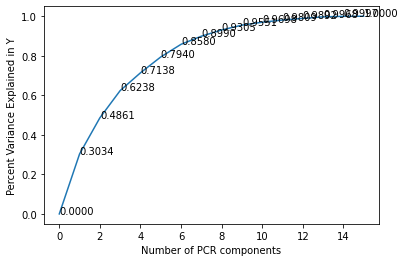

In [14]:
# 绘制主成分的累计贡献率(响应变量中解释的方差百分比)与组件数量的碎石图
comp = range(0, p+1)
# 主成分的累计贡献率(计算方差百分比)
summ = 0
W_sum = [0]
for i in range(p):
    summ += W_srt[i]
    W_sum.append(summ / p)
plt.plot(comp, W_sum)
plt.xlabel('Number of PCR components')
plt.ylabel('Percent Variance Explained in Y')
for i,j in zip(comp, W_sum):
    plt.text(i, j, '%.4f' % float(j))

In [15]:
#选择使累计贡献率达到80%的主成分
c_pc = 0.8
cnt = True
thres = p * c_pc
while cnt:
    W_sum = 0
    W_summ = W_srt[0] 
    for i in range(p-1):
        k1 = i + 1 
        W_sum += W_srt[i]
        W_summ += W_srt[i+1]
        # print(i,W_sum,W_summ,thres)
        if (W_sum < thres) & (W_summ >= thres):
            cnt = False
            break
        elif i == p - 2:
            cnt = False
            k1 = i + 1
            break
k1 = k1 + 1
print('保留变量个数为: ', k1) 

保留变量个数为:  6


In [16]:
# 删除特征值接近于零的主成分
for i in range(p):
    if W_srt[i] < 1:
        k2 = i
        break
print('保留变量个数为: ', k2)

保留变量个数为:  5


In [17]:
# 均方误差确定 k
mse = 0
for i in range(p):
    k3 = p
    mse += 1 / W_srt[i]
    print(5 * (i + 1), mse)
    if mse > 5 * (i + 1):
        k3 = i
        break
    elif i == p-1:
        k3 = p
        break
print('保留变量个数 <=', k3) 

5 0.21972379563756939
10 0.5846284245805907
15 1.0686646047055377
20 1.8101291270623892
25 2.6410452033164553
30 3.6820482481339374
35 5.3097919692811875
40 7.427522835355704
45 10.136546993030667
50 14.671760786906987
55 20.683421876990195
60 28.66704501412042
65 37.39676603702543
70 60.959993170108014
75 266.347777327897
保留变量个数 <= 14


综上，选择保留变量的个数为 5.

## Q2:对降维后的数据进行回归分析

In [18]:
# 矩阵拆分
k = k2
list_var1 = W_idx[0:k] # 记录降序排序后的前 k 个主成分
list_var2 = W_idx[k:]


Z_1 = Z[:,list_var1]
Z_2 = Z[:,list_var2]

W_diag_1 = np.diag(W_diag[list_var1,list_var1])
W_diag_2 = np.diag(W_diag[list_var2,list_var2])

# 按行进行拆分
V_1 = V[list_var1,:]
V_2 = V[list_var2,:]

# α的估计
alpha1_hat = np.linalg.inv(W_diag_1) @ Z_1.T @ Y_tr
print('系数:', alpha1_hat)

# 主成分估计
beta_pc = np.dot(V_1.T,alpha1_hat)
print(beta_pc)

系数: [-119.46515583   25.02124187  150.63296393  -25.25172939    0.51944394]
[ 34.83909236  -4.02528198  35.32518257 -17.44233607  50.8866548
 -91.40722783 -45.44692353  57.72321108  56.57234575 -68.04348771
  45.92335266   9.76435403  22.69185812  77.60962126 -50.29099857]


In [19]:
# 使用拆分后的数据用线性回归模型进行建模
X_pc = Z_1

#添加截距项
z=np.ones(59)
X_pc=np.c_[z,X_pc]

model_pc = sm.OLS(Y_tr, X_pc).fit()
model_pc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     10.67
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           4.00e-07
Time:                        16:28:53   Log-Likelihood:                -306.85
No. Observations:                  59   AIC:                             625.7
Df Residuals:                      53   BIC:                             638.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        940.1198      6.030    155.906      0.000     928.025     952.215
x1          -119.4652     21.711     -5.502      0.000    -163.012     -75.918
x2            25.0212     27.979      0.894      0.375     -31.098      81.140
x3           150.6330     32.224      4.675      0.000      85.999     215.267
x4           -25.2517     39.883     -0.633      0.529    -105.247      54.744
x5             0.5194     42.221      0.012      0.990     -84.164      85.203
==============================================================================
Omnibus:                        0.423   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.809   Jarque-Bera (JB):                0.104
Skew:                          -0.088   Prob(JB):                        0.949
Kurtosis:                       3.106   Cond. No.                         7.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
judge_col(X_pc, thres_vif=5, thres_kappa=10)

VIF方法判断结果(阈值为 5): 
设计矩阵 X 不存在多重共线性

特征值判定法判断结果(阈值为 10): 
设计矩阵 X 不存在多重共线性，其中kappa值为：2.1766


In [21]:
# 第二种利用pca
# 创建pca模型
pca = PCA(n_components=5)

# 对模型进行训练
X_pc_ = X_std * 1.0
pca.fit(X_pc_)

# 返回降维后数据
X_pc_ = pca.transform(X_pc_)

#添加截距项
X_pc_=np.c_[z,X_pc_]

# 使用返回后的数据用线性回归模型进行建模
model_pc_ = sm.OLS(Y_tr, X_pc_).fit()
model_pc_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     10.67
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           4.00e-07
Time:                        16:28:54   Log-Likelihood:                -306.85
No. Observations:                  59   AIC:                             625.7
Df Residuals:                      53   BIC:                             638.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        940.1198      6.030    155.906      0.000     928.025     952.215
x1          -119.4652     21.711     -5.502      0.000    -163.012     -75.918
x2            25.0212     27.979      0.894      0.375     -31.098      81.140
x3           150.6330     32.224      4.675      0.000      85.999     215.267
x4           -25.2517     39.883     -0.633      0.529    -105.247      54.744
x5             0.5194     42.221      0.012      0.990     -84.164      85.203
==============================================================================
Omnibus:                        0.423   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.809   Jarque-Bera (JB):                0.104
Skew:                          -0.088   Prob(JB):                        0.949
Kurtosis:                       3.106   Cond. No.                         7.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
judge_col(X_pc_, thres_vif=5, thres_kappa=10)

VIF方法判断结果(阈值为 5): 
设计矩阵 X 不存在多重共线性

特征值判定法判断结果(阈值为 10): 
设计矩阵 X 不存在多重共线性，其中kappa值为：2.1766


## Q3:选择适当的岭参数.
岭参数 $k$ 选择(模型选择)的方法:   
1. 岭迹法
2. 方差扩大因子法
3. 霍尔-肯纳德（Hoerl-Kennad）公式

1. 岭迹法  
岭迹法的一般原则:   
· 系数岭估计基本稳定;    
· 最小二乘回归下符号不合理的回归系数, 在岭估计的意义下符号变得合理;    
· 回归系数合乎经济意义;  
· 残差平方和不会增大太多.

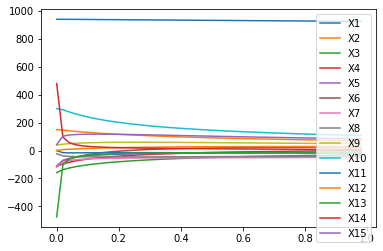

<function __main__.RR1(K=1)>

In [23]:
# [0, 1) 范围内划分的最大精细程度: [0,0.01,0.02,...,0.99]
range_const1 = 100

def RR1(K = 1):
    # 计算岭估计
    rang1 = []
    for i in range(K):
        rang1.append(i/K) # 岭参数 k 取值范围: [0,1-1/K](例如 K=10, k 取值范围: [0, 0.9])
    coefs_1 = []
    for k in rang1:
        temp1 = np.linalg.inv(X_std.T @ X_std + k * np.eye(p+1)) @ X_std.T @ Y_tr
        coefs_1.append(temp1)

    # 画图
    #print('参数的数值: ', coefs_1)
    coefs_1 = np.array(coefs_1)
    for i in range(p):
        plt.plot(rang1, coefs_1[:,i], label = 'X%d'%(i+1))
    plt.legend(loc = 'best')

# 随着 K 值的增加, 岭参数 k 取值越精细, 因为在 [0,1) 范围内的分割更细
interact(RR1,K=(50))

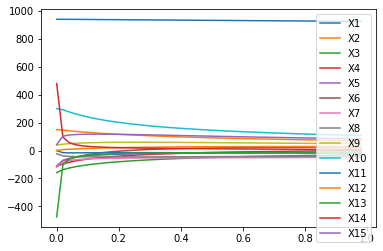

<function __main__.RR2(K=1)>

In [24]:
# 调包: linear_model 
def RR2(K = 1): 
    # 初始化一个Ridge Regression
    clf = linear_model.Ridge(fit_intercept=False)

    # 训练模型: 测试不同的 k 取值，获得系数
    rang2 = []
    for i in range(K):
        rang2.append(i/K)
    coefs_2 = []
    for k in rang2:
        clf.set_params(alpha=k)
        clf.fit(X_std, Y_tr)
        coefs_2.append(clf.coef_)

    # 画图
    # print('参数的数值: ', coefs_2)
    coefs_2 = np.array(coefs_2)
    for i in range(p):
        plt.plot(rang2, coefs_2[:,i], label = 'X%d'%(i+1))   
    plt.legend(loc = 'best')

interact(RR2,K=(50))

In [25]:
# 初始化一个Ridge Cross-Validation Regression
clf_cv = linear_model.RidgeCV(fit_intercept=False)
 
# 训练模型
clf_cv.fit(X_std, Y_tr)

k_cv = clf_cv.alpha_
coef_cv = clf_cv.coef_ 
print('k 的数值 : ', clf_cv.alpha_)
print('参数的数值：', clf_cv.coef_)

k 的数值 :  0.1
参数的数值： [ 938.52910321  129.90234705 -102.23633387  -60.96000159  -38.23199552
  -29.58488104  -60.10127822  -44.93189207   55.4977486   240.17045526
  -15.90155782   14.85830603  -33.18862534   29.92396451  116.98022656
   13.19914415]


In [26]:
# 验证岭估计和最小二乘估计之间的关系
thres_k = int(k_cv * range_const1)
print(coef_cv)

C1 = X_std.T @ X_std
C2 = np.linalg.inv(C1 + k_cv * np.eye(p+1))
C3 = C2 @ C1
print(C3 @ beta_std_hat)

diff = coef_cv - C3 @ beta_std_hat
print('差异: ', diff)

[ 938.52910321  129.90234705 -102.23633387  -60.96000159  -38.23199552
  -29.58488104  -60.10127822  -44.93189207   55.4977486   240.17045526
  -15.90155782   14.85830603  -33.18862534   29.92396451  116.98022656
   13.19914415]
[ 938.52910321  129.90234705 -102.23633387  -60.96000159  -38.23199552
  -29.58488104  -60.10127822  -44.93189207   55.4977486   240.17045526
  -15.90155782   14.85830603  -33.18862534   29.92396451  116.98022656
   13.19914415]
差异:  [ 1.81898940e-11 -4.43378667e-12  3.97903932e-13 -2.97006864e-12
 -3.33244543e-12  2.11741735e-12  1.69819714e-12  3.20454774e-12
 -3.75166564e-12 -1.10844667e-12 -3.05533376e-12  3.90798505e-14
  4.20641300e-12  1.36779477e-12  2.65742983e-12 -1.31095135e-12]


2. 方差扩大因子法

岭参数为:  0.049787068367863944
对应的岭估计:  [ 939.32718057  139.32451556 -120.41767566  -79.19175213  -51.88652371
  -54.64856924  -68.55989289  -42.50949085   50.69634764  269.66121219
  -16.56699534    9.96248559  -53.5729058    48.05887504  112.96711171
    9.17611504]


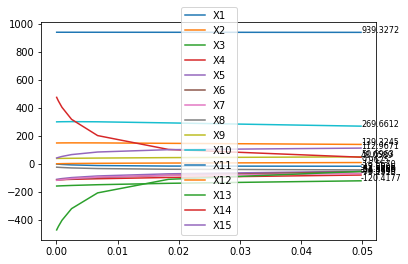

In [27]:
coefs_4 = []
thres_vif = 5
num_lambda4 = 30
judge = True
for k in range(num_lambda4):
    cnt = 0
    C = np.linalg.inv(C1 + np.exp(k-10) * np.eye(p+1)) @ C1 @np.linalg.inv(C1 + np.exp(k-10) * np.eye(p+1))
    temp4 = np.linalg.inv(X_std.T @ X_std + np.exp(k-10) * np.eye(p+1)) @ X_std.T @ Y_tr
    coefs_4.append(temp4)
    # 给定 k, 使得所有方差扩大因子 C[j][j] <= thres_vif
    for j in range(p):
        if C[j][j] < thres_vif:
            cnt += 1
        else:
            break
    if cnt == p:
        k4 = np.exp(k-10)
        print('岭参数为: ', np.exp(k-10))
        print('对应的岭估计: ', temp4)
        break

# 画图
coef_4 = temp4
x4 = []  # 以 np.exp(k) 作为横坐标
for i in range(k+1):
     x4.append(np.exp(i-10))
coefs_4 = np.array(coefs_4)
for i in range(p):
    plt.plot(x4, coefs_4[:,i], label = 'X%d'%(i+1))
    plt.text(x4[-1], coefs_4[-1,i], '%.4f' % float(coefs_4[-1,i]), fontsize=8)

plt.legend(loc = 'best')
plt.show()

3. 霍尔-肯纳德（Hoerl-Kennad）公式



$$
\ k_{\mathrm{HK}}=\frac{\hat{\sigma}^{2}}{\max _{j} \hat{\alpha}_{j}^{2}}
$$

In [28]:
X_std2=X_std[:,1:]

In [29]:
X_std2.shape

(59, 15)

In [30]:
#求sigma
sigma = sum((Y_tr - Y_std_hat) ** 2) / (n - p - 1)
alpha_hat = np.linalg.inv(W_diag) @ Z.T @ Y_tr
k_HK = sigma / max(alpha_hat**2)
print('岭参数 k_HK: ', k_HK)
coef_5 =  np.linalg.inv(X_std.T @ X_std + np.exp(k_HK-10) * np.eye(p+1)) @ X_std.T @ Y_tr
print('对应的岭估计: ', coef_5)

岭参数 k_HK:  0.0026889028484862808
对应的岭估计:  [ 9.40119105e+02  1.49602200e+02 -1.57732542e+02 -1.13262956e+02
 -1.09985910e+02 -1.14869848e+02 -1.16976957e+02 -2.31824681e+01
  3.92371464e+01  3.00450524e+02 -7.11289855e-01  1.15227388e+00
 -4.71037204e+02  4.75326066e+02  4.24502353e+01  5.65015115e+00]


## Q4. 进行岭回归分析并在测试用例上做预测，比较最小二乘、主成分回归和岭回归建立的模型在测试集上的效果.

In [31]:
#岭回归 确定岭参数k的函数
def choose_k(num_lambda4,X_std,Y_tr,coefs_4):
    for k in range(num_lambda4):
        cnt = 0
        C1 = X_std.T @ X_std
        C = np.linalg.inv(C1 + np.exp(k-10) * np.eye(p+1)) @ C1 @np.linalg.inv(C1 + np.exp(k-10) * np.eye(p+1))
        temp4 = np.linalg.inv(X_std.T @ X_std + np.exp(k-10) * np.eye(p+1)) @ X_std.T @ Y_tr
        coefs_4.append(temp4)
        # 给定 k, 使得所有方差扩大因子 C[j][j] <= thres_vif
        for j in range(p):
            if C[j][j] < thres_vif:
                cnt += 1
            else:
                break
        if cnt == p:
            k4 = np.exp(k-10)
            break
    return k4

In [32]:
#主成分回归的函数
def pca(X_std,Y_tr,test_X,test_y):
    #求 (X*)'(X*) 矩阵
    R = np.dot(X_std.T,X_std) 
    R = pd.DataFrame(R[1:,1:])
    # 求特征值 & 特征向量
    W, V = np.linalg.eig(R)
    # 对特征值按降序排序
    W_srt = W.tolist()
    W_srt.sort(reverse=True)
    # 主成分的累计贡献率(计算方差百分比)
    summ = 0
    W_sum = [0]
    for i in range(p):
        summ += W_srt[i]
        W_sum.append(summ / p)
    #选择使累计贡献率达到80%的主成分
    c_pc = 0.8
    cnt = True
    thres = p * c_pc
    while cnt:
        W_sum = 0
        W_summ = W_srt[0] 
        for i in range(p-1):
            k1 = i + 1 
            W_sum += W_srt[i]
            W_summ += W_srt[i+1]
            if (W_sum < thres) & (W_summ >= thres):
                cnt = False
                break
            elif i == p - 2:
                cnt = False
                k1 = i + 1
                break
    k1 = k1 + 1
    # 删除特征值接近于零的主成分
    for i in range(p):
        if W_srt[i] < 1:
            k2 = i
            break
        # 矩阵拆分
    k=k2
    # 创建pca模型
    pca = PCA(n_components=k)

    # 对模型进行训练
    X_pc_ = X_std * 1.0
    pca.fit(X_pc_)

    # 返回降维后数据
    X_pc_ = pca.transform(X_pc_)
    model_pc_ = sm.OLS(Y_tr, X_pc_).fit()
    tx=pca.transform(test_X)
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_pc_,Y_tr)   # 模型训练
    y_pred = lr.predict(tx)
    RMSE3=np.sqrt(np.mean(np.square(test_y - y_pred)))
    return RMSE3

**采用留一法展示60种模型在60种测试用例上的效果（以RMSE为指标）**

In [33]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
cnt=0
RMSE1_=[]
RMSE2_=[]
RMSE3_=[]
for train, test in loo.split(X):
    cnt=cnt+1
    print('第',cnt,'个模型')
    train_X, test_X, train_y, test_y = X_std_1[train],X_std_1[test],Y[train],Y[test]
    model_std = sm.OLS(train_y, train_X).fit()
    beta_std_hat = model_std.params
    coefs_4=[]
    k4=choose_k(num_lambda4,train_X,train_y,coefs_4)
    Y_tst_hat = test_X @ beta_std_hat
    Y_tst_rr = test_X @ coef_4
    
    #计算两种预测结果的RMSE
    RMSE1 = np.sqrt(np.mean(np.square(test_y - Y_tst_hat)))
    RMSE2 = np.sqrt(np.mean(np.square(test_y - Y_tst_rr)))
    RMSE3 = pca(train_X,train_y,test_X,test_y)
    print("k=",k4)
    print('使用最小二乘估计进行预测的结果的RMSE是', RMSE1)
    print('使用岭估计进行预测的结果的RMSE是', RMSE2)
    print('使用主成分回归估计进行预测的结果的RMSE是', RMSE3)
    RMSE1_.append(RMSE1)
    RMSE2_.append(RMSE2)
    RMSE3_.append(RMSE3)

第 1 个模型
k= 0.049787068367863944
使用最小二乘估计进行预测的结果的RMSE是 19.904495334564217
使用岭估计进行预测的结果的RMSE是 15.13436254350745
使用主成分回归估计进行预测的结果的RMSE是 7.9970261193742544
第 2 个模型
k= 0.049787068367863944
使用最小二乘估计进行预测的结果的RMSE是 89.74544109029364
使用岭估计进行预测的结果的RMSE是 78.74187249061197
使用主成分回归估计进行预测的结果的RMSE是 87.90514583956258
第 3 个模型
k= 0.049787068367863944
使用最小二乘估计进行预测的结果的RMSE是 42.593391011560925
使用岭估计进行预测的结果的RMSE是 39.746163420642574
使用主成分回归估计进行预测的结果的RMSE是 5.1522190339899225
第 4 个模型
k= 0.049787068367863944
使用最小二乘估计进行预测的结果的RMSE是 1.1106611846228134
使用岭估计进行预测的结果的RMSE是 1.9977332444611875
使用主成分回归估计进行预测的结果的RMSE是 16.974323859014135
第 5 个模型
k= 0.049787068367863944
使用最小二乘估计进行预测的结果的RMSE是 27.713279424109032
使用岭估计进行预测的结果的RMSE是 23.319276543243404
使用主成分回归估计进行预测的结果的RMSE是 61.62631266331027
第 6 个模型
k= 0.049787068367863944
使用最小二乘估计进行预测的结果的RMSE是 72.4698569474042
使用岭估计进行预测的结果的RMSE是 39.66436252202129
使用主成分回归估计进行预测的结果的RMSE是 7.654949732890373
第 7 个模型
k= 0.049787068367863944
使用最小二乘估计进行预测的结果的RMSE是 34.63002975511972
使用岭估计进行预测的结果的RMSE是 

**绘图展示结果**

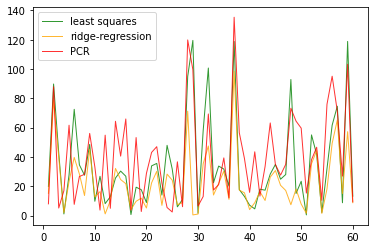

In [34]:
import matplotlib.pyplot as plt
import numpy as np
p=np.linspace(1,60,60)
plt.plot(p, RMSE1_, color='green', alpha=0.8, linewidth=1, label="least squares")
plt.plot(p, RMSE2_, color='orange', alpha=0.8, linewidth=1, label='ridge-regression')
plt.plot(p, RMSE3_, color='red', alpha=0.8, linewidth=1, label='PCR')
plt.legend()

上图显示的结果为最小二乘、主成分回归和岭回归建立的模型在测试集上的效果